In this notebook, we devise a method to identify very coarse niche types in mouse brain. 

Main brain components:

- Cortex, full of neurons like excitatory
- Striatum, full of inhibitory neurons.
- White matter, full of oligodendrocytes who generate myelin,

Microglia are immune cells in the brain

Astrocytes are everywhere but more close to boundaries,

We can assume more macrophages in the old mice

We can use this dataset to compare niches from different ages

endothelial cells = surrounds the blood vessels

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker
from scvi.strip_metrics import SpatialAnalysis

from anndata import AnnData

import torch

In [4]:
scvi.settings.seed = 34

Global seed set to 34


In [5]:
# !ls /home/labs/nyosef/Collaboration/SpatialDatasets/merfish/BrainAgingSpatialAtlas_MERFISH

!ls /home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/

adata_MERFISH_24w.h5ad
adata_scvi_merfish4w.h5ad
BrainAging_MERFISH_4weeks_major_ct.h5ad
BrainAgingSpatialAtlas_MERFISH_24weeks.h5ad
BrainAgingSpatialAtlas_MERFISH_4weeks.h5ad
BrainAgingSpatialAtlas_MERFISH.h5ad
BrainAgingSpatialAtlas_MERFISH.ipynb


In [6]:
plots = False

In [7]:
data_dirs = {
    "VIZGEN_Liver": [
        "/home/nathanlevy/Data/Liver_VIZGEN/",
        "liver-joint-scvi3-annotated.h5ad",
    ],
    "MERFISH_Brain": [
        # "/home/labs/nyosef/Collaboration/SpatialDatasets/merfish/BrainAgingSpatialAtlas_MERFISH/",
        "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/",
        "adata_scvi_merfish4w.h5ad",
    ],
    "NANOSTRING_Lung": [
        "/home/nathanlevy/Data/",
        "nanostring_bis_finished_hotspot_densities.h5ad",
    ],
}

In [8]:
# data_dir = "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/"
# data_file = "adata_scvi_merfish4w.h5ad"

data_dir, data_file = data_dirs["MERFISH_Brain"]

data_file_name = os.path.splitext(data_file)[0]
print(data_file_name)

adata_scvi_merfish4w

In [9]:
path_to_save = os.path.join("checkpoints", data_file_name)
os.makedirs(path_to_save, exist_ok=True)

In [10]:
adata = ad.read_h5ad(data_dir + data_file)
print(adata)

AnnData object with n_obs × n_vars = 123632 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice', 'n_counts', 'cell_index', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'donor_id_colors', 'log1p', 'neighbors', 'pca', 
'umap'
    obsm: 'X_pca', 'X_scVI', 'X_spVI', 'X_spatial', 'X_umap', 'centroids', 'neighborhood_composition', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [11]:
cell_types = adata.obs.cell_type.unique().tolist()
int_to_cell_type = {i: cell_types[i] for i in range(len(cell_types))}
int_to_cell_type

{0: 'endothelial cell',
 1: 'oligodendrocyte precursor cell',
 2: 'neuron',
 3: 'astrocyte',
 4: 'inhibitory interneuron',
 5: 'pericyte',
 6: 'oligodendrocyte',
 7: 'microglial cell',
 8: 'vascular leptomeningeal cell',
 9: 'medium spiny neuron',
 10: 'macrophage',
 11: 'T cell',
 12: 'cell'}

In [12]:
adata.obs["niche_type"] = "unknown"

In [13]:
adata.obsm["neighborhood_composition"]

array([[0.14814815, 0.11111111, 0.55555556, ..., 0.        , 0.        ,
        0.        ],
       [0.18181818, 0.09090909, 0.54545455, ..., 0.        , 0.        ,
        0.        ],
       [0.13793103, 0.13793103, 0.51724138, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4       , 0.05      , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.2       , 0.1       , ..., 0.        , 0.        ,
        0.        ],
       [0.2173913 , 0.17391304, 0.04347826, ..., 0.        , 0.        ,
        0.        ]])

In [14]:
adata.obs.cell_type.value_counts()

cell_type
neuron                            34553
medium spiny neuron               25667
oligodendrocyte                   13110
astrocyte                         12830
endothelial cell                  11376
inhibitory interneuron            10330
microglial cell                    6317
oligodendrocyte precursor cell     4234
pericyte                           3443
vascular leptomeningeal cell       1137
macrophage                          355
cell                                235
T cell                               45
Name: count, dtype: int64

In [15]:
neighborhood_composition = pd.DataFrame(
    adata.obsm["neighborhood_composition"], columns=cell_types
)
neighborhood_composition

,endothelial cell,oligodendrocyte precursor cell,neuron,astrocyte,inhibitory interneuron,pericyte,oligodendrocyte,microglial cell,vascular leptomeningeal cell,medium spiny neuron,macrophage,T cell,cell
0,0.148148,0.111111,0.555556,0.037037,0.111111,0.000000,0.037037,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.181818,0.090909,0.545455,0.090909,0.045455,0.000000,0.045455,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.137931,0.137931,0.517241,0.068966,0.034483,0.000000,0.103448,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.150000,0.100000,0.550000,0.000000,0.100000,0.000000,0.000000,0.100000,0.0,0.0,0.0,0.0,0.0
4,0.130435,0.173913,0.434783,0.086957,0.086957,0.000000,0.086957,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123627,0.400000,0.050000,0.050000,0.050000,0.300000,0.150000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
123628,0.350000,0.150000,0.100000,0.050000,0.150000,0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
123629,0.400000,0.050000,0.100000,0.050000,0.250000,0.150000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
123630,0.250000,0.200000,0.100000,0.050000,0.300000,0.050000,0.000000,0.050000,0.0,0.0,0.0,0.0,0.0


In [19]:
# Niche1 = neuron
# Niche2 = medium spiny neuron
# Niche3 = astrocyte
# Niche4 = oligodendrocyte
# Niche5 = microglia

# cell_types = ["microglial cell"]

# for sample in adata.obs.donor_slice.unique().tolist()[:]:
#     sc.pl.spatial(
#         adata=adata[
#             adata.obs["cell_type"].isin(cell_types)
#             & (adata.obs["donor_slice"] == sample)
#         ],
#         spot_size=40,
#         color=["cell_type"],
#         ncols=2,
#         frameon=False,
#         title=sample,
#     )



In [72]:
# Niche1 = neuron  2
# Niche2 = medium spiny neuron  9
# Niche3 = astrocyte 3
# Niche4 = oligodendrocyte 6
# Niche5 = microglia 7

In [16]:
# filter rows that have adata.obsm['neighborhood_composition'] column index 2 > 0.2 and retrieve the row indexes:

treshold = 0.3333

cell_type_index = 2
cell_type = int_to_cell_type[cell_type_index]

niches = [2, 3, 6, 9]

neighborhood_composition_niches = neighborhood_composition.iloc[:, niches]

for cell_type_index in niches:
    cell_type = int_to_cell_type[cell_type_index]
    adata.obs.niche_type[
        adata.obsm["neighborhood_composition"][:, cell_type_index] > treshold
    ] = cell_type

/tmp/ipykernel_2368268/3167995157.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.niche_type[


In [17]:
adata.obs.niche_type.value_counts()

niche_type
neuron                 39008
unknown                34948
medium spiny neuron    31317
oligodendrocyte        13448
astrocyte               4911
Name: count, dtype: int64

In [18]:
niche_types = adata.obs.niche_type.unique().tolist()
niche_types

['neuron', 'unknown', 'oligodendrocyte', 'astrocyte', 'medium spiny neuron']

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


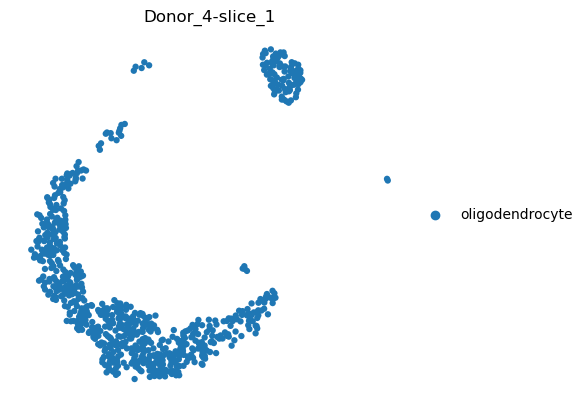

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


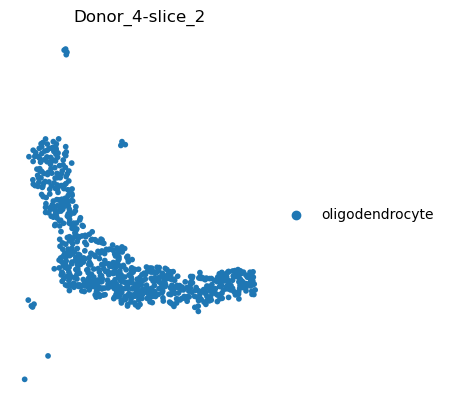

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


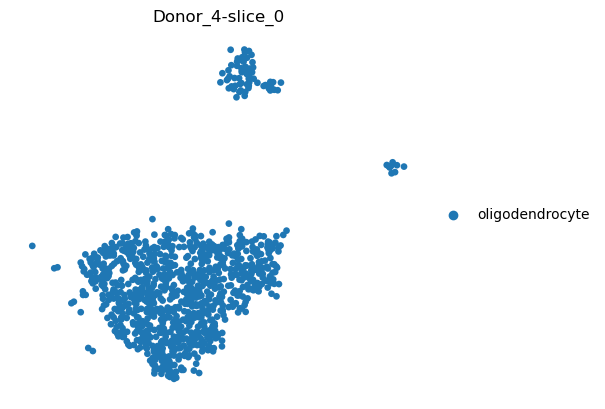

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


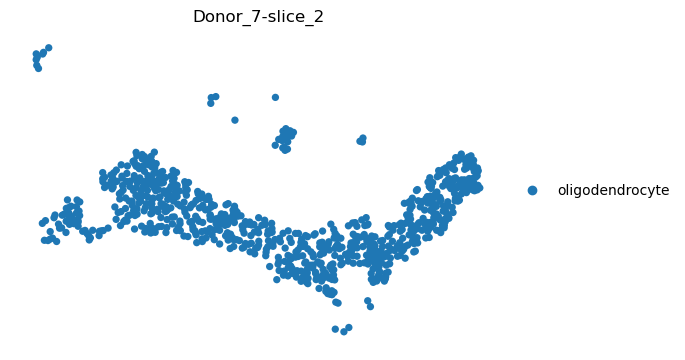

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


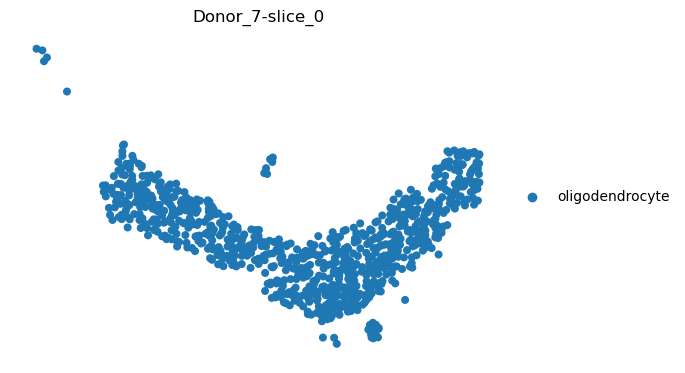

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


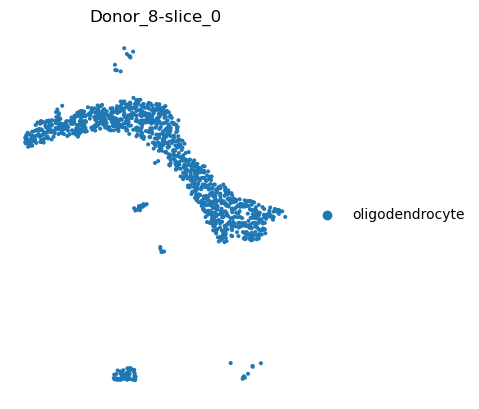

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


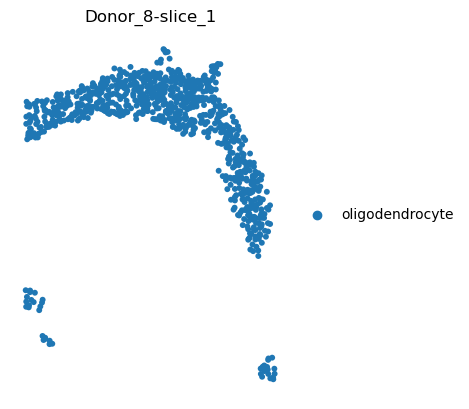

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


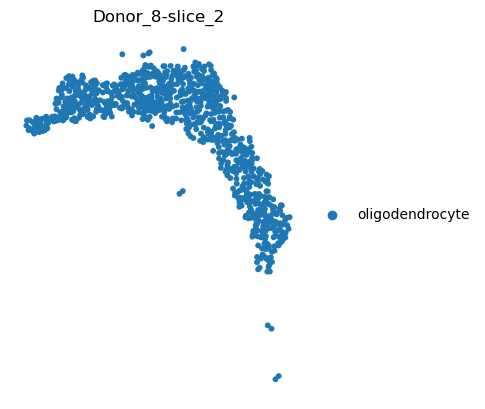

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


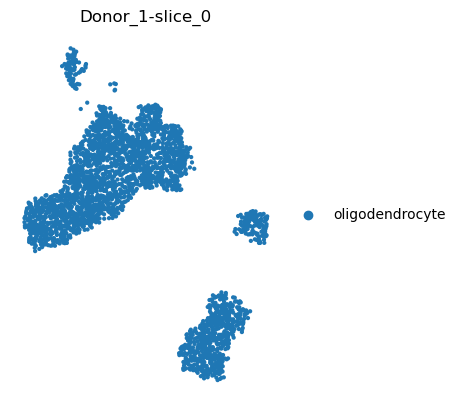

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


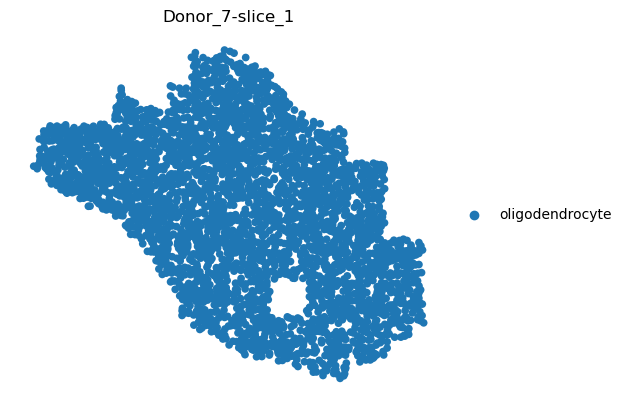

In [109]:
for sample in adata.obs.donor_slice.unique().tolist()[:]:
    sc.pl.spatial(
        adata=adata[
            adata.obs["niche_type"].isin(["oligodendrocyte"])
            & (adata.obs["donor_slice"] == sample)
        ],
        spot_size=40,
        color=["niche_type"],
        ncols=1,
        frameon=False,
        title=sample,
    )

In [121]:
# Define the threshold
threshold = 0.3333

# Check which values are greater than the threshold
greater_than_threshold = adata.obsm["neighborhood_composition"][:, niches] > threshold

# Sum the True values in each row (axis=1) to count the number of values greater than the threshold
count_greater = np.sum(greater_than_threshold, axis=1)

# Get the value counts for the counts
value_counts = np.bincount(count_greater)

value_counts

array([34948, 87720,   964])

In [123]:
neighborhood_composition.iloc[:, niches][count_greater == 2]

,neuron,astrocyte,oligodendrocyte,medium spiny neuron
1010,0.350000,0.000000,0.450000,0.0
1014,0.380952,0.047619,0.333333,0.0
1018,0.333333,0.047619,0.380952,0.0
1026,0.428571,0.047619,0.333333,0.0
1052,0.521739,0.043478,0.347826,0.0
...,...,...,...,...
121503,0.043478,0.347826,0.434783,0.0
121525,0.047619,0.333333,0.476190,0.0
122028,0.043478,0.391304,0.347826,0.0
122034,0.050000,0.350000,0.500000,0.0


In [197]:
neighborhood_composition.mean(axis=0)

endothelial cell                  0.093888
oligodendrocyte precursor cell    0.045545
neuron                            0.202483
astrocyte                         0.100572
inhibitory interneuron            0.155010
pericyte                          0.044983
oligodendrocyte                   0.118568
microglial cell                   0.045717
vascular leptomeningeal cell      0.014415
medium spiny neuron               0.172585
macrophage                        0.004027
T cell                            0.000365
cell                              0.001842
dtype: float64

In [190]:
neighborhood_composition = pd.DataFrame(
    adata.obsm["neighborhood_composition"], columns=cell_types
)
neighborhood_composition_niches = neighborhood_composition.iloc[:, niches]

max_ct = neighborhood_composition_niches.max(axis=1)

df = neighborhood_composition_niches  # .copy()

# Create a new column with the name of the column containing the maximum value for each row
df["niche_assignment"] = df.idxmax(axis=1)

# Set 'max_column' to 'unknown' for rows where the maximum value is less than the threshold
df.loc[max_ct < 0.2, "niche_assignment"] = "unknown"

/tmp/ipykernel_1584113/2154981468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["niche_assignment"] = df.idxmax(axis=1)


In [191]:
df["niche_assignment"].value_counts()

niche_assignment
neuron                 42502
medium spiny neuron    31410
unknown                24769
oligodendrocyte        14529
astrocyte              10422
Name: count, dtype: int64

In [184]:
def get_cell_niches(
    adata: AnnData,
    cell_types_to_include: list[str],
    treshold: float = 0.2,
    niche_type_key: str = "niche_type",
    niche_composition_key: str = "niche_composition",
):
    composition_subet = neighborhood_composition[cell_types_to_include]

    # for each cell, get the cell type with the highest proportion in its neighborhood

    max_ct = composition_subet.max(axis=1)

    # Create a new column with the name of the column containing the maximum value for each row
    composition_subet["niche_assignment"] = composition_subet.idxmax(axis=1)

    # Set 'max_column' to 'unknown' for rows where the maximum value is less than the threshold
    composition_subet.loc[max_ct < treshold, "niche_assignment"] = "unknown"

    adata.obs[niche_type_key] = composition_subet["niche_assignment"].values

    return None

In [185]:
get_cell_niches(
    adata,
    cell_types_to_include=[
        "neuron",
        "oligodendrocyte",
        "astrocyte",
        "medium spiny neuron",
    ],
    niche_composition_key="neighborhood_composition",
)

/tmp/ipykernel_1584113/3149659337.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  composition_subet["niche_assignment"] = composition_subet.idxmax(axis=1)


In [186]:
adata.obs["niche_type"].value_counts()

niche_type
neuron                 42502
medium spiny neuron    31410
unknown                24769
oligodendrocyte        14731
astrocyte              10220
Name: count, dtype: int64

In [221]:
stat = ["mean", "std"]
multi_idx = pd.MultiIndex.from_product(
    [neighborhood_composition.columns, stat], names=["cell type", "stat"]
)

In [220]:
neighborhood_composition.columns.tolist()

['endothelial cell',
 'oligodendrocyte precursor cell',
 'neuron',
 'astrocyte',
 'inhibitory interneuron',
 'pericyte',
 'oligodendrocyte',
 'microglial cell',
 'vascular leptomeningeal cell',
 'medium spiny neuron',
 'macrophage',
 'T cell',
 'cell']

In [218]:
df = pd.DataFrame(
    data=[], index=multi_idx, columns=pd.Index(["A", "B", "C", "D"], name="cluster")
)
df

cluster                                A    B    C    D
cell type                      stat                    
endothelial cell               mean  NaN  NaN  NaN  NaN
                               std   NaN  NaN  NaN  NaN
oligodendrocyte precursor cell mean  NaN  NaN  NaN  NaN
                               std   NaN  NaN  NaN  NaN
neuron                         mean  NaN  NaN  NaN  NaN
                               std   NaN  NaN  NaN  NaN
astrocyte                      mean  NaN  NaN  NaN  NaN
                               std   NaN  NaN  NaN  NaN
inhibitory interneuron         mean  NaN  NaN  NaN  NaN
                               std   NaN  NaN  NaN  NaN

In [231]:
df = pd.DataFrame(
    np.random.randn(3, len(multi_idx)), index=["A", "B", "C"], columns=multi_idx
)
df

cell type endothelial cell           oligodendrocyte precursor cell            \
stat                  mean       std                           mean       std   
A                 1.541291  1.310127                      -0.594181 -0.066922   
B                -1.024503  0.317852                      -0.949025 -0.101161   
C                 0.402902  0.906653                       0.980003 -1.279017   

cell type    neuron           astrocyte           inhibitory interneuron  \
stat           mean       std      mean       std                   mean   
A          0.048902 -0.023037 -1.318195 -0.546703              -0.450539   
B          0.144671 -0.856898 -0.101895 -0.281181              -0.325689   
C         -0.108951 -0.098775 -0.299767  1.175900               0.976180   

cell type            ... vascular leptomeningeal cell            \
stat            std  ...                         mean       std   
A         -0.415695  ...                    -1.824921  0.650109   
B         -1.276665  ...                     0.664228 -0.463626   
C          1.052884  ...                     1.725901  0.953601   

cell type medium spiny neuron           macrophage              T cell  \
stat                     mean       std       mean       std      mean   
A                   -2.087075 -0.748056   0.151622  1.068552  0.312916   
B                   -0.758068  0.261649  -1.152322  0.684155 -0.097495   
C                   -0.117405  0.097911   1.601058 -0.144762  1.668261   

cell type                cell            
stat            std      mean       std  
A          0.154385 -0.515064 -0.754032  
B         -1.816570 -0.513995 -1.066933  
C         -1.723381  0.668928  0.064071  

[3 rows x 26 columns]

In [233]:
df["astrocyte", "mean"]

A   -1.318195
B   -0.101895
C   -0.299767
Name: (astrocyte, mean), dtype: float64

In [234]:
df.T

A         B         C
cell type                      stat                              
endothelial cell               mean  1.541291 -1.024503  0.402902
                               std   1.310127  0.317852  0.906653
oligodendrocyte precursor cell mean -0.594181 -0.949025  0.980003
                               std  -0.066922 -0.101161 -1.279017
neuron                         mean  0.048902  0.144671 -0.108951
                               std  -0.023037 -0.856898 -0.098775
astrocyte                      mean -1.318195 -0.101895 -0.299767
                               std  -0.546703 -0.281181  1.175900
inhibitory interneuron         mean -0.450539 -0.325689  0.976180
                               std  -0.415695 -1.276665  1.052884
pericyte                       mean -2.113228  0.737442  0.001419
                               std  -1.401720 -0.483496 -0.761579
oligodendrocyte                mean  1.516984  0.806349  1.095467
                               std  -0.747409  1.857976 -0.181204
microglial cell                mean  0.690587 -0.299780 -0.759387
                               std  -0.205107 -0.721792  0.182227
vascular leptomeningeal cell   mean -1.824921  0.664228  1.725901
                               std   0.650109 -0.463626  0.953601
medium spiny neuron            mean -2.087075 -0.758068 -0.117405
                               std  -0.748056  0.261649  0.097911
macrophage                     mean  0.151622 -1.152322  1.601058
                               std   1.068552  0.684155 -0.144762
T cell                         mean  0.312916 -0.097495  1.668261
                               std   0.154385 -1.816570 -1.723381
cell                           mean -0.515064 -0.513995  0.668928
                               std  -0.754032 -1.066933  0.064071

In [39]:
cell_counts = np.array([1, 2, 4, 6, 3, 0], dtype=np.float32)

In [40]:
cell_counts_prop = cell_counts / cell_counts.sum()

In [41]:
def softmax(x, temperature=2):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp((x - x.max(axis=1).reshape(-1, 1)) / temperature)

    softmax = e_x / e_x.sum(axis=1).reshape(-1, 1)
    return softmax.round(3)

In [37]:
softmax(cell_counts.reshape(1, -1), temperature=1)

array([[0.006, 0.015, 0.112, 0.825, 0.041, 0.002]], dtype=float32)

In [38]:
softmax(cell_counts.reshape(1, -1), temperature=0.5)

array([[0.   , 0.   , 0.018, 0.979, 0.002, 0.   ]], dtype=float32)

In [43]:
np.log(cell_counts_prop + 1e-6)

array([ -2.7725728 ,  -2.0794337 ,  -1.3862903 ,  -0.98082656,
        -1.6739712 , -13.815511  ], dtype=float32)

In [19]:
from scipy.stats import entropy

In [28]:
entropy(neighborhood_composition.loc[0], neighborhood_composition)

(13,)

In [ ]:
entropy(neighborhood_composition)